# *Reading DF*

In [1]:
from google.colab import files

# upload kaggle API key for downloading data (json format)
uploaded = files.upload()
for fn in uploaded.keys():
  print(f"File {fn} was uploaded")

# move kaggle.json into folder where API expects to find it
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle (1).json to kaggle (1).json
File kaggle (1).json was uploaded
mv: cannot stat 'kaggle.json': No such file or directory


In [2]:
# https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset
!kaggle datasets download -d pranavraikokte/covid19-image-dataset

Dataset URL: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset
License(s): CC-BY-SA-4.0
 94% 149M/158M [00:00<00:00, 173MB/s]
100% 158M/158M [00:01<00:00, 158MB/s]


In [3]:
from zipfile import ZipFile
file_path = "/content/covid19-image-dataset.zip"
with ZipFile(file_path, 'r') as zip_file:
  zip_file.extractall()
  print('Extraction Compelted')

Extraction Compelted


# Imports

In [4]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint
from  tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [5]:
import random
train = []
test = []

train_path = '/content/Covid19-dataset/train'
test_path = '/content/Covid19-dataset/test'

for folder in os.listdir(train_path):
  images_path = os.path.join(train_path, folder)

  for filename in os.listdir(images_path):
    full_path = os.path.join(images_path, filename)
    img = cv2.imread(full_path)
    train.append((img, folder))

for folder in os.listdir(test_path):
  images_path = os.path.join(test_path, folder)

  for filename in os.listdir(images_path):
    full_path = os.path.join(images_path, filename)
    img = cv2.imread(full_path)
    test.append((img, folder))

random.shuffle(train)
random.shuffle(test)
len(train),len(test)


(251, 66)

# Full Data Info

In [6]:
full_data = []
full_data.extend(train)
full_data.extend(test)
len(full_data)

317

In [7]:
labes = []
for i in full_data:
  labes.append(i[1])

Freq of each category

In [8]:
pd.Series(labes).value_counts()

,count
Covid,137
Normal,90
Viral Pneumonia,90


In [9]:
import plotly.express as px
fig = px.pie(values=pd.Series(labes).value_counts(), names=pd.Series(labes).value_counts().index,hole=0.425)
fig.update_layout(title_text='Freq of each category',title_x=0.45)
fig.show()

In [10]:
fig = px.bar(x=pd.Series(labes).value_counts().index,y=pd.Series(labes).value_counts(),title='Freq of each category')
fig.update_layout(title_text='Freq of each category',title_x=0.45)
fig.show()

Some Info from Data:

1.   most of people has covid
2.   number of total data are small so i may need to generate data


**Getting Optimal size**

In [11]:
size = []
for i in full_data:
  h = i[0].shape[0]
  w = i[0].shape[1]
  size.append(i[0].shape)
set(size),np.mean(h),np.mean(w)

({(341, 416, 3),
  (362, 439, 3),
  (362, 445, 3),
  (391, 436, 3),
  (391, 439, 3),
  (400, 523, 3),
  (448, 425, 3),
  (480, 844, 3),
  (557, 556, 3),
  (631, 790, 3),
  (640, 1208, 3),
  (648, 872, 3),
  (655, 651, 3),
  (659, 651, 3),
  (662, 890, 3),
  (663, 881, 3),
  (664, 785, 3),
  (678, 681, 3),
  (679, 827, 3),
  (695, 849, 3),
  (700, 888, 3),
  (720, 1410, 3),
  (732, 895, 3),
  (733, 918, 3),
  (733, 972, 3),
  (734, 892, 3),
  (734, 895, 3),
  (734, 977, 3),
  (739, 767, 3),
  (744, 1464, 3),
  (760, 1280, 3),
  (776, 1160, 3),
  (792, 1352, 3),
  (813, 1272, 3),
  (816, 999, 3),
  (816, 1248, 3),
  (816, 1268, 3),
  (832, 1152, 3),
  (840, 1056, 3),
  (840, 1064, 3),
  (840, 1168, 3),
  (840, 1248, 3),
  (840, 1408, 3),
  (841, 1107, 3),
  (842, 1024, 3),
  (842, 1090, 3),
  (856, 1192, 3),
  (856, 1224, 3),
  (856, 1256, 3),
  (859, 1210, 3),
  (864, 1344, 3),
  (871, 1206, 3),
  (872, 1216, 3),
  (872, 1280, 3),
  (872, 1520, 3),
  (872, 1544, 3),
  (874, 880, 3),
  (

In [12]:
for indx,item in enumerate(full_data):
  img = item[0]
  img = cv2.resize(img,(856,1256))
  full_data[indx] = (img,item[1])

In [13]:
size = []
for i in full_data:
  h = i[0].shape[0]
  w = i[0].shape[1]
  size.append(i[0].shape)
set(size),np.mean(h),np.mean(w)

({(1256, 856, 3)}, 1256.0, 856.0)

# Train,Cv,Test Info

In [14]:
train = full_data[:190]
cv = full_data[190:253]
test = full_data[253:]

In [15]:
import plotly.express as px
# Train data distribution
train_labels = [i[1] for i in train]
fig = px.pie(values=pd.Series(train_labels).value_counts(), names=pd.Series(train_labels).value_counts().index,hole=0.425)
fig.update_layout(title_text='Train Data Distribution',title_x=0.45)
fig.show()

# CV data distribution
cv_labels = [i[1] for i in cv]
fig = px.pie(values=pd.Series(cv_labels).value_counts(), names=pd.Series(cv_labels).value_counts().index,hole=0.425)
fig.update_layout(title_text='CV Data Distribution',title_x=0.45)
fig.show()

# Test data distribution
test_labels = [i[1] for i in test]
fig = px.pie(values=pd.Series(test_labels).value_counts(), names=pd.Series(test_labels).value_counts().index,hole=0.425)
fig.update_layout(title_text='Test Data Distribution',title_x=0.45)
fig.show()


# Prepare Data for Model

In [16]:
train_images,train_labels = zip(*train)
cv_images,cv_labels = zip(*cv)
test_images,test_labels = zip(*test)

train_images = np.array(train_images)
cv_images = np.array(cv_images)
test_images = np.array(test_images)

from  sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
cv_labels = le.fit_transform(cv_labels)
test_labels = le.fit_transform(test_labels)

from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels,num_classes=3)
cv_labels = to_categorical(cv_labels,num_classes=3)
test_labels = to_categorical(test_labels,num_classes=3)

In [17]:
train_images.shape,cv_images.shape,test_images.shape

((190, 1256, 856, 3), (63, 1256, 856, 3), (64, 1256, 856, 3))

# CNN

In [19]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential

CNN_Model = Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(1256,856,3)),
    MaxPooling2D(2,2),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3,activation='softmax')
])

CNN_Model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
CNN_Model.fit(train_images,train_labels,epochs=15,validation_data=(cv_images,cv_labels))

Epoch 1/15
6/6 [==============================] - 50s 8s/step - loss: 0.6757 - accuracy: 0.7158 - val_loss: 17.2340 - val_accuracy: 0.3492
Epoch 2/15
6/6 [==============================] - 48s 8s/step - loss: 0.3919 - accuracy: 0.8632 - val_loss: 5.9526 - val_accuracy: 0.4444
Epoch 3/15
6/6 [==============================] - 48s 8s/step - loss: 0.3028 - accuracy: 0.9000 - val_loss: 7028.3828 - val_accuracy: 0.3333
Epoch 4/15
6/6 [==============================] - 48s 8s/step - loss: 0.3201 - accuracy: 0.8789 - val_loss: 8.8094 - val_accuracy: 0.4444
Epoch 5/15
6/6 [==============================] - 48s 8s/step - loss: 0.2137 - accuracy: 0.9421 - val_loss: 31.7280 - val_accuracy: 0.3333
Epoch 6/15
6/6 [==============================] - 48s 8s/step - loss: 0.1584 - accuracy: 0.9579 - val_loss: 12.8432 - val_accuracy: 0.3333
Epoch 7/15
6/6 [==============================] - 48s 8s/step - loss: 0.1795 - accuracy: 0.9579 - val_loss: 39.4906 - val_accuracy: 0.3333
Epoch 8/15
6/6 [===========

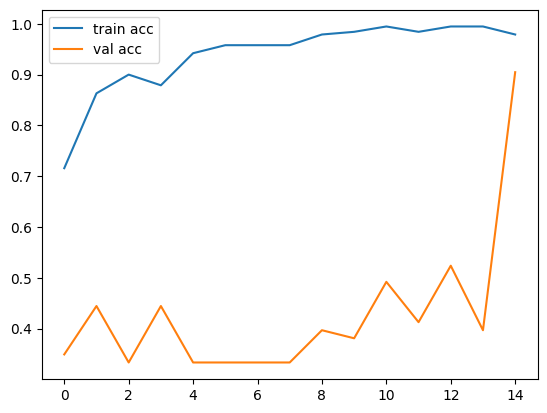

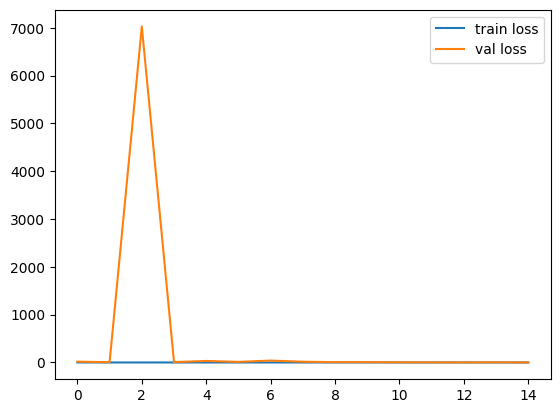

<Figure size 640x480 with 0 Axes>

In [20]:
plt.plot(CNN_Model.history.history['accuracy'], label='train acc')
plt.plot(CNN_Model.history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

plt.plot(CNN_Model.history.history['loss'], label='train loss')
plt.plot(CNN_Model.history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


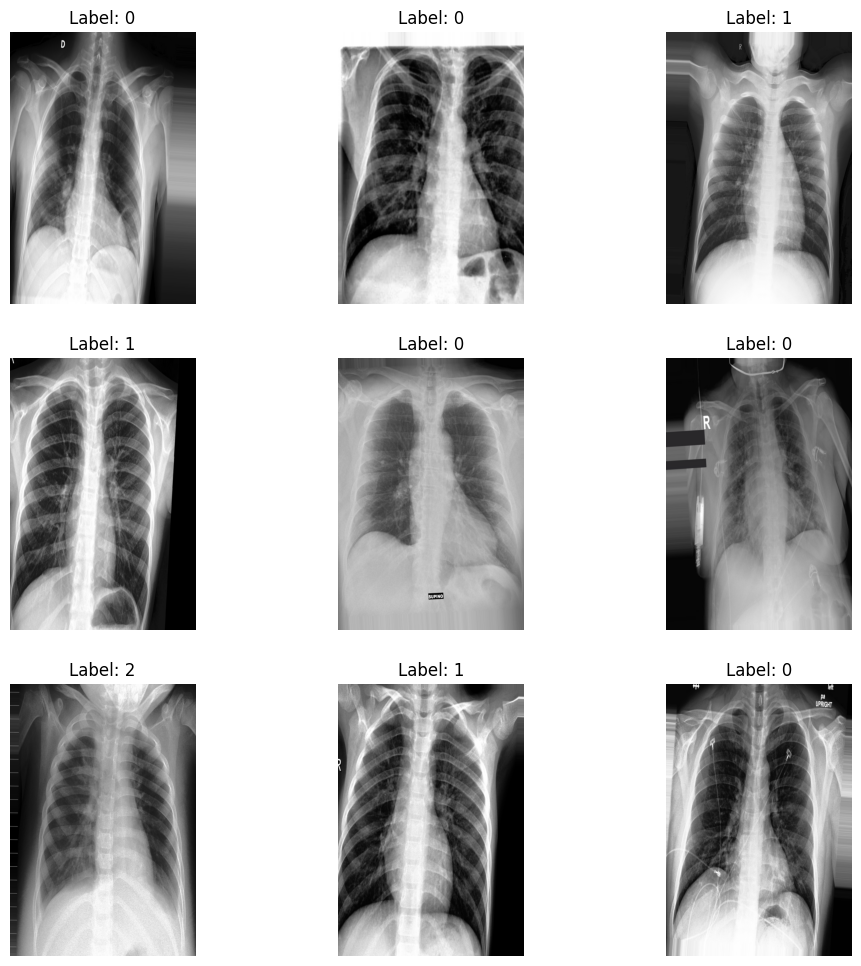

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
)

cv_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generating batches of augmented images from train set
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)

# Generating batches of images from cv and test sets
cv_generator = cv_datagen.flow(cv_images, cv_labels, batch_size=32)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32)

plt.figure(figsize=(12, 12))
for i in range(9):
    x_batch, y_batch = train_generator.next()
    image = x_batch[0]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {np.argmax(y_batch[0])}")
    plt.axis('off')

plt.show()


In [25]:
CNN_Model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=cv_generator,
)

Epoch 1/15
6/6 [==============================] - 68s 11s/step - loss: 0.4862 - accuracy: 0.8211 - val_loss: 3.7472 - val_accuracy: 0.4127
Epoch 2/15
6/6 [==============================] - 69s 11s/step - loss: 0.3570 - accuracy: 0.8737 - val_loss: 3.7315 - val_accuracy: 0.4127
Epoch 3/15
6/6 [==============================] - 69s 11s/step - loss: 0.2825 - accuracy: 0.9000 - val_loss: 3.7164 - val_accuracy: 0.4127
Epoch 4/15
6/6 [==============================] - 70s 11s/step - loss: 0.3325 - accuracy: 0.8684 - val_loss: 54.6708 - val_accuracy: 0.2540
Epoch 5/15
6/6 [==============================] - 69s 11s/step - loss: 0.2963 - accuracy: 0.8842 - val_loss: 31.4754 - val_accuracy: 0.2540
Epoch 6/15
6/6 [==============================] - 68s 11s/step - loss: 0.3806 - accuracy: 0.8579 - val_loss: 33.9674 - val_accuracy: 0.2540
Epoch 7/15
6/6 [==============================] - 70s 11s/step - loss: 0.3142 - accuracy: 0.8684 - val_loss: 17.8787 - val_accuracy: 0.2540
Epoch 8/15
6/6 [=======

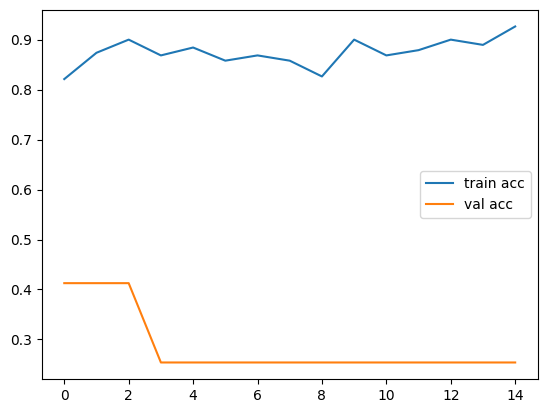

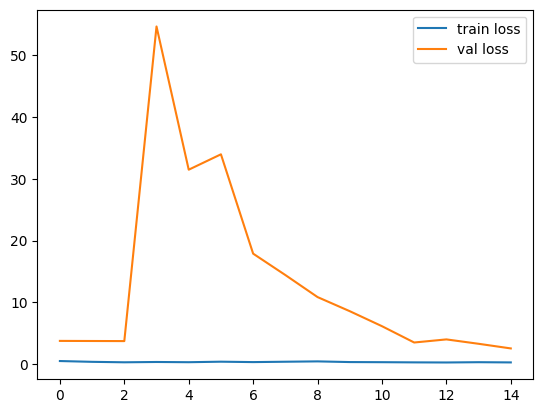

<Figure size 640x480 with 0 Axes>

In [26]:
plt.plot(CNN_Model.history.history['accuracy'], label='train acc')
plt.plot(CNN_Model.history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

plt.plot(CNN_Model.history.history['loss'], label='train loss')
plt.plot(CNN_Model.history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


Some Hints :

1.   As the data are very small so there is overfitting
2.   After Try Data Augmentation the overfitting is still great



# Transfer Learning

ResNet 50

In [27]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(1256, 856, 3))

# Freeze the layers of the base model
for layer in base_model.layers[:-5]:
  layer.trainable = False

# Build the head of the model
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(128, activation='relu'),
  Dropout(0.5),
  Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
    train_images,train_labels,
    epochs=15,
    validation_data=(cv_images,cv_labels)
)


94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/15
6/6 [==============================] - 91s 15s/step - loss: 3.3058 - accuracy: 0.5316 - val_loss: 56.4442 - val_accuracy: 0.4286
Epoch 2/15
6/6 [==============================] - 88s 15s/step - loss: 1.2458 - accuracy: 0.7842 - val_loss: 12.9778 - val_accuracy: 0.6349
Epoch 3/15
6/6 [==============================] - 89s 16s/step - loss: 0.5503 - accuracy: 0.8632 - val_loss: 12.7206 - val_accuracy: 0.6508
Epoch 4/15
6/6 [==============================] - 90s 16s/step - loss: 0.2402 - accuracy: 0.9053 - val_loss: 4.6076 - val_accuracy: 0.6349
Epoch 5/15
6/6 [==============================] - 89s 16s/step - loss: 0.1345 - accuracy: 0.9526 - val_loss: 1.5744 - val_accuracy: 0.8254
Epoch 6/15
6/6 [==============================] - 90s 16s/step - loss: 0.1073 - accuracy: 0.9526 - val_loss: 0.4027 - val_accuracy: 0.9048
Epoch 7/15
6/6 [==============================] - 90s 16s/step - loss: 0.0557 - accuracy: 0.9895 -

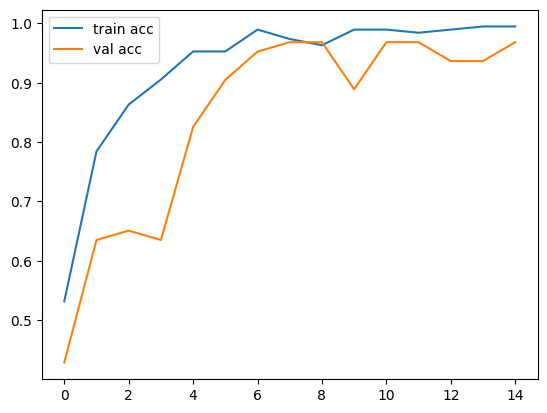

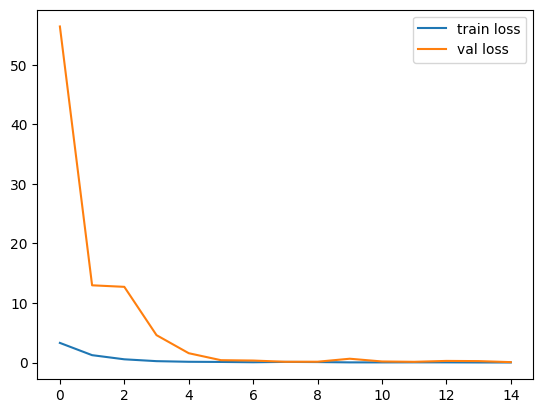

<Figure size 640x480 with 0 Axes>

In [28]:
plt.plot(model.history.history['accuracy'], label='train acc')
plt.plot(model.history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

plt.plot(model.history.history['loss'], label='train loss')
plt.plot(model.history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


In [29]:
model.evaluate(test_images,test_labels)

2/2 [==============================] - 22s 11s/step - loss: 0.0681 - accuracy: 0.9688


[0.06813480705022812, 0.96875]

2/2 [==============================] - 23s 11s/step


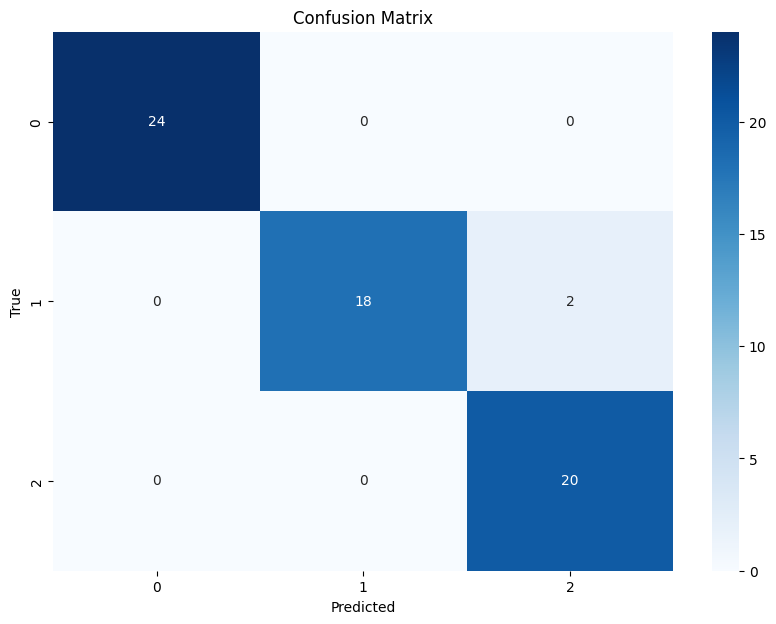

In [30]:
# Predict classes for test data
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


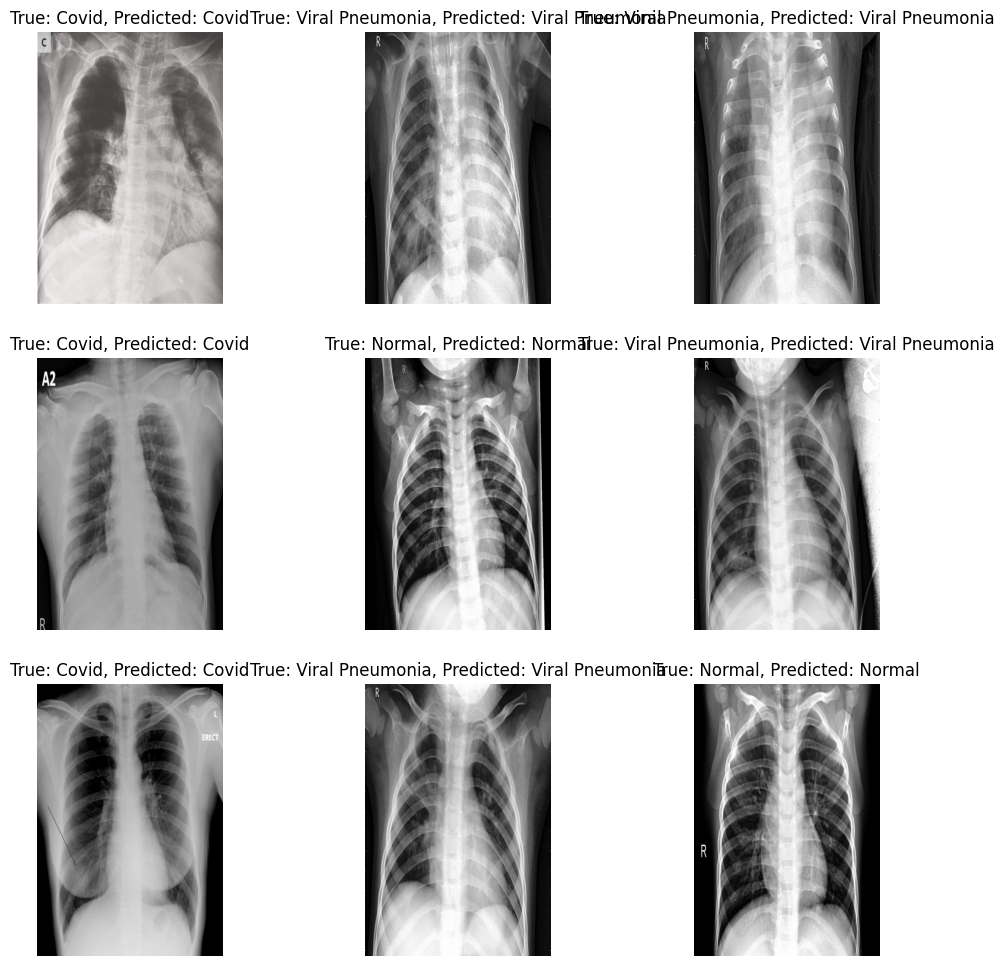

In [31]:
# Get indices of correctly classified images
correct_indices = np.where(y_pred_classes == y_true)[0]

# Plot some correctly classified images
plt.figure(figsize=(12, 12))
for i, idx in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[idx] / 255.0)  # Assuming images are normalized
    plt.title(f"True: {le.classes_[y_true[idx]]}, Predicted: {le.classes_[y_pred_classes[idx]]}")
    plt.axis('off')

plt.show()
